___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Assignment-2 (CNN)<br><br>Image Classification with CNN<br><h1>

# Ammar's Summary


- Read about the problem
- import libraries
- import dataset
- Try to understand the dataset
    - Check the distribution of target classes
    - Including viewing some random images
- Data Preprocessing:
        - Scale the train & test images (0, 1) instead of (0, 255)
        - Add a channel dimension since it is 1 channel so not already there
        - encode the target so the machine does not understand it is a regression problem
- Build 2 models:
    - 1- Vanilla CNN model as the minimum requirements
    - 2- Another model with Recall of class 6 as the metric since it was the least accuracy in the 1st model
        - Optuna tuning was preformed with this
        - It improved recall of class 6 but gave similar accuracy with the vanilla one
        - For the final model, the vanilla model was chosen since both gives similar results but it is less costly
        - We saved the model
- Prediction part:
    - Loaded the model
    - Chose a random image from the testing data (since we don't have a real data to test it)
    - Apply scaling
    - Add a forth dimension (number of observations to be predicted -in this case it is 1)
    - Predict
    - It gave a correct prediction


# Task and Dataset Info

Welcome to second assignment of Deep learning lesson. Follow the instructions and complete the assignment.

**Build an image classifier with Convolutional Neural Networks for the Fashion MNIST dataset. This data set includes 10 labels of different clothing types with 28 by 28 *grayscale* images. There is a training set of 60,000 images and 10,000 test images.**

    Label	Description
    0	    T-shirt/top
    1	    Trouser
    2	    Pullover
    3	    Dress
    4	    Coat
    5	    Sandal
    6	    Shirt
    7	    Sneaker
    8	    Bag
    9	    Ankle boot

# Import Libraries

In [92]:
import pandas as pd  # For manipulating dataframes
import numpy as np   # For arrays and matmetical stuff
import matplotlib.pyplot as plt # For visulaization
import seaborn as sns # For visulaization

# For data preprocessing [splitting, tranformation, encoding, make pipelines]
from sklearn.model_selection import train_test_split # splitting
from tensorflow.keras.utils import to_categorical # To do one-hot encoding for the target column


# for evaluating classificaiton probelms
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay



# For the DNN model [create & monitor]
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation   # needed for ANN
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten,     BatchNormalization # need for CNN
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, Nadam   # Optimizers
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping

from livelossplot import PlotLossesKeras  #live change for the loss plot after each epoch
 
# For DNN hyperparamter tuning 
import optuna

# for predciton part
from tensorflow.keras.models import load_model     # Load models
from tensorflow.keras.preprocessing import image   

%matplotlib inline

#plt.rcParams["figure.figsize"] = (10,6)
# To ignore warining
import warnings
warnings.filterwarnings('ignore')

# To change maximum rows to 50
pd.set_option('display.max_rows', 50)

In [40]:
import tensorflow as tf

if tf.config.list_physical_devices("GPU"):
    print("GPU support is enabled for this session.")
else:
    print("CPU will be used for this session.")


GPU support is enabled for this session.


In [42]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
SEED = 42
tf.keras.utils.set_random_seed(SEED)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

In [67]:
import os

# Set TF log level to ignore INFOs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

# Recognizing and Understanding Data

**TASK 1: Run the code below to download the dataset using Keras.**

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
def shape(X_train, y_train, X_test, y_test):
    return (print("Shape of x_train:", X_train.shape) ,
            print(
                 "Shape of y_train:", y_train.shape),
            print(
                 "Shape of x_test:", X_test.shape),
            print(
                 "Shape of y_test:", y_test.shape),
           )

In [4]:
# Check shape of each subset
shape(X_train, y_train, X_test, y_test)

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


(None, None, None, None)

In [6]:
# Check the balance of the classes
df = pd.DataFrame(y_train, columns = ['Column_A'])
df.value_counts()

Column_A
0           6000
1           6000
2           6000
3           6000
4           6000
5           6000
6           6000
7           6000
8           6000
9           6000
Name: count, dtype: int64

it is perfectly balanced

**TASK 2: Use matplotlib to view an image from the data set. It can be any image from the data set.**

In [7]:
classes=["T-shirt/top", "Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [8]:
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

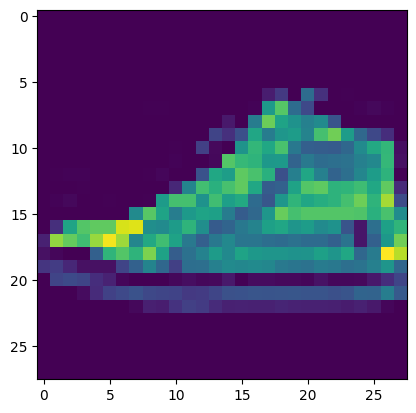

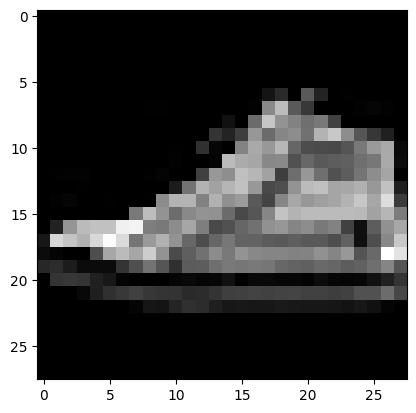

This image is: Sneaker


In [9]:
#  view a rnadom image from the training data

# Pick the index of the image
import random
i = random.randint(0, len(X_train)-1)

#  view the scale image 
display(plt.imshow(X_train[i]))
plt.show()

#  view the gray scale image 
display(plt.imshow(X_train[i], cmap="gray"))
plt.show()


# What is its class
print("This image is:", classes[y_train[i]])



# Data Preprocessing

**TASK 3: Normalize the X train and X test data by dividing by the max value of the image arrays.**

We can apply MinMax scaler which is (value-min)/range, since the minimum pixel value is 0
<br>
The formula becomes just value/max

In [10]:
# Check before normalizing 
print(X_train.min())
print(X_train.max())

0
255


In [11]:
# Normalize image pixels  [MinMAx Scaler]  (value-min) /range
# To make the values from 0 to 255  to be from 0 -1
# This help to stabilize the training process

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train /= 255
X_test /= 255

In [12]:
# Check after normalizing 

print(X_train.min())
print(X_train.max())


0.0
1.0


**Task 4: Reshape the X arrays to include a 4 dimension of the single channel. Similar to what we did for the numbers MNIST data set.**

In [13]:
# Check shape before
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Add the forth dimension (The channel)

In [14]:
X_train = np.expand_dims(X_train, 3)
X_test = np.expand_dims(X_test, 3)

In [15]:
# Check shape after
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


**TASK 5: Convert the y_train and y_test values to be one-hot encoded for categorical analysis by Keras.**

Now each y observation is just a single number, whcih may be think of as a regression problem. <br>
Therefore, we will convert each y-observations into a row of 10 values, 9 zeros and 1 one <br>
(the 1 represent the truth class in the training data)

In [16]:
#from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

# Check shape of one observation
print("Shape before:",y_test[0])
print("Shape after:",Y_test[0])


Shape before: 9
Shape after: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


# Modeling

## Create the model

**TASK 5: Use Keras to create a model consisting of at least the following layers (but feel free to experiment):**

* 2D Convolutional Layer, filters=28 and kernel_size=(3,3)
* Pooling Layer where pool_size = (2,2) strides=(1,1)

* Flatten Layer
* Dense Layer (128 Neurons, but feel free to play around with this value), RELU activation

* Final Dense Layer of 10 Neurons with a softmax activation

**Then compile the model with these parameters: loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']**

In [17]:
model = Sequential()
NumFilter = 28
FilterSize = (3, 3)


model.add(
    Conv2D(NumFilter, kernel_size=FilterSize, input_shape=(28, 28, 1), activation="relu")
)  # stride = 1, padding = valid

model.add(MaxPool2D(pool_size=(2, 2), strides =  (1, 1)))  

model.add(Flatten())

model.add(Dense(128, activation="relu"))

model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

##  Model Training 

**TASK 6: Train/Fit the model to the x_train set by using EarlyStop. Amount of epochs is up to you.**
<br>
**&**
<br>
**TASK 7: Plot values of metrics you used in your model.**

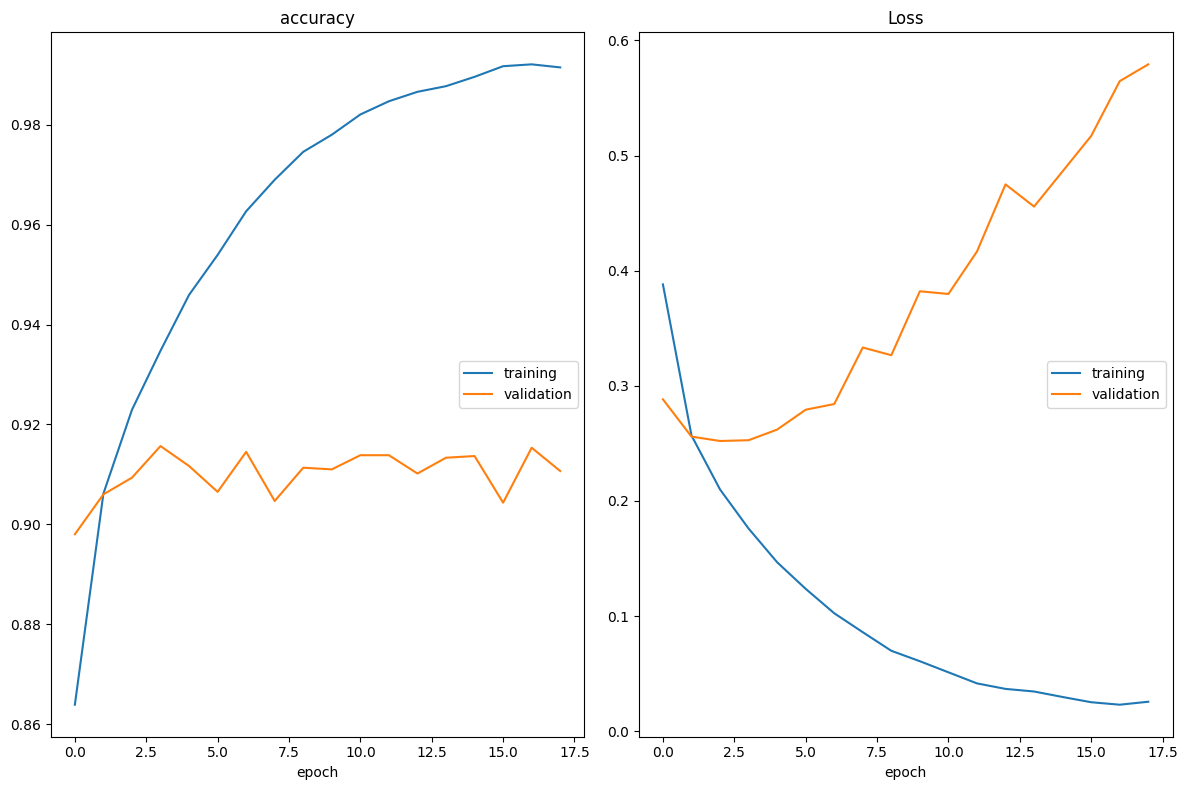

accuracy
	training         	 (min:    0.864, max:    0.992, cur:    0.992)
	validation       	 (min:    0.898, max:    0.916, cur:    0.911)
Loss
	training         	 (min:    0.023, max:    0.388, cur:    0.026)
	validation       	 (min:    0.252, max:    0.579, cur:    0.579)
Restoring model weights from the end of the best epoch: 3.
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0256 - accuracy: 0.9915 - val_loss: 0.5793 - val_accuracy: 0.9107
Epoch 18: early stopping


In [18]:
# Stop training when a monitored metric has stopped improving.
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True
)  # mode is min; because the min th e loss the better

# We are readt to fit the data
model.fit(
    x=X_train,
    y=Y_train,
    validation_split=0.1,
    batch_size=32,
    epochs=1000, 
    verbose=1,  # 1000 epoch since there is early stopping
    callbacks=[PlotLossesKeras(), early_stop])  # We add the erarly stop

## Model Evaluation

**TASK 8: Show the accuracy,precision,recall,f1-score the model achieved on the x_test data set. Keep in mind, there are quite a few ways to do this, but we recommend following the same procedure we showed in the MNIST lecture.**

In [24]:
score = model.evaluate(x= X_test, y = Y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.2744 - accuracy: 0.9006
Test loss: 0.27439039945602417
Test accuracy: 0.900600016117096


In [30]:
# Get the predctions probabilties [value for each class]
pred_prob = model.predict(X_test)

# Convert it into 1-D array
# the indexs of each maximum probability
y_pred = np.argmax(pred_prob, axis=1)
print(y_pred)
print(y_pred.shape)


313/313 [==============================] - 1s 2ms/step
[9 2 1 ... 8 1 5]
(10000,)


In [38]:
from sklearn.metrics import classification_report, confusion_matrix
def eval_metric(model, X_train, y_train, X_test, y_test):
    pred_prob = model.predict(X_train)
    y_train_pred = np.argmax(pred_prob, axis=1)    
    pred_prob = model.predict(X_test)
    y_pred = np.argmax(pred_prob, axis=1)
    
    print("Test_Set")
    plt.figure(figsize=(15, 10))
    sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    cmap="Blues",
    linewidths=0.5,
    linecolor="black",
    fmt="g",
    annot_kws={"size": 15},
    )
    plt.show()    
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    plt.figure(figsize=(15, 10))
    sns.heatmap(
    confusion_matrix(y_train, y_train_pred),
    annot=True,
    cmap="Blues",
    linewidths=0.5,
    linecolor="black",
    fmt="g",
    annot_kws={"size": 15},
    )
    plt.show()    
    print(classification_report(y_train, y_train_pred))
    


313/313 [==============================] - 0s 1ms/step
Test_Set


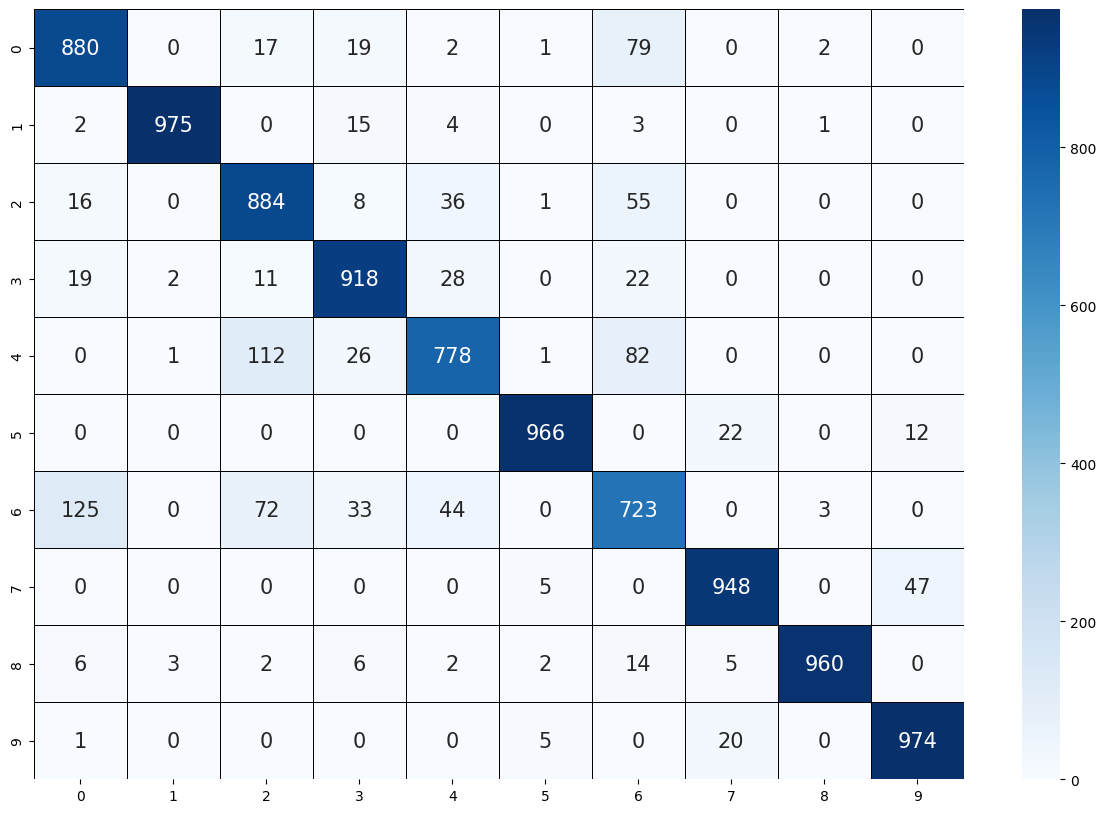

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.88      0.84      1000
           3       0.90      0.92      0.91      1000
           4       0.87      0.78      0.82      1000
           5       0.98      0.97      0.98      1000
           6       0.74      0.72      0.73      1000
           7       0.95      0.95      0.95      1000
           8       0.99      0.96      0.98      1000
           9       0.94      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


Train_Set


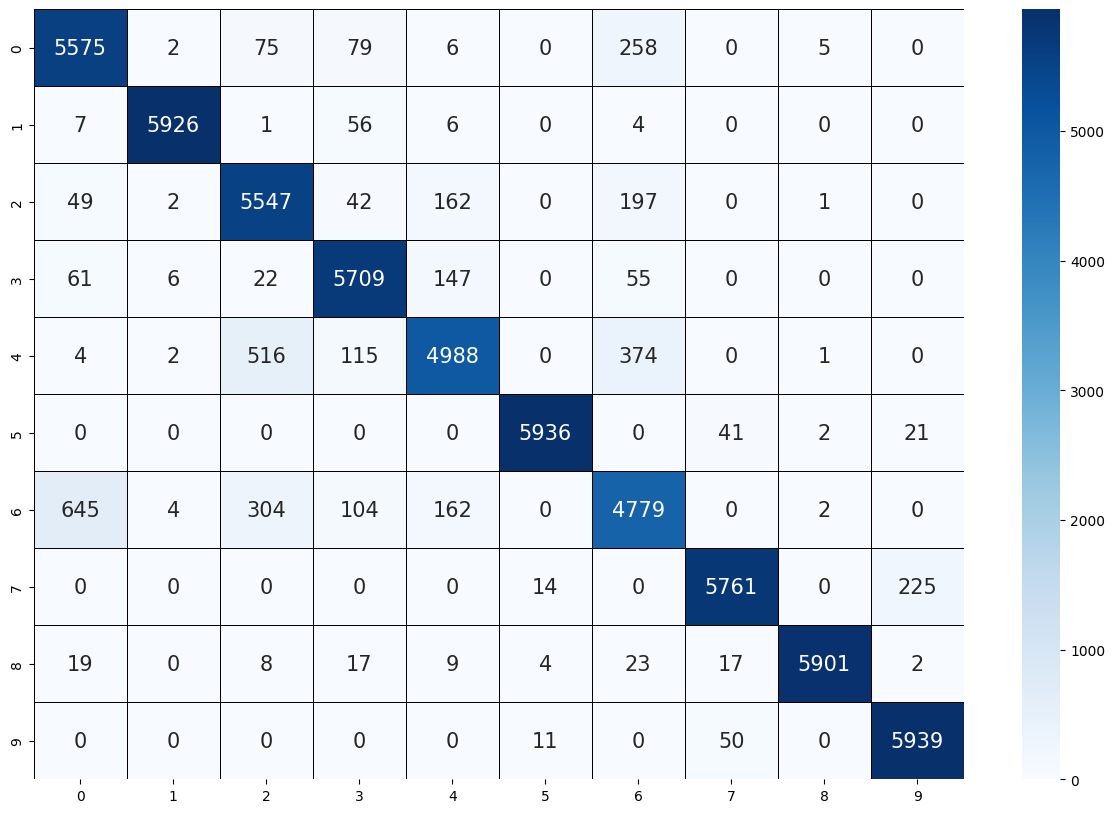

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6000
           1       1.00      0.99      0.99      6000
           2       0.86      0.92      0.89      6000
           3       0.93      0.95      0.94      6000
           4       0.91      0.83      0.87      6000
           5       1.00      0.99      0.99      6000
           6       0.84      0.80      0.82      6000
           7       0.98      0.96      0.97      6000
           8       1.00      0.98      0.99      6000
           9       0.96      0.99      0.97      6000

    accuracy                           0.93     60000
   macro avg       0.93      0.93      0.93     60000
weighted avg       0.93      0.93      0.93     60000



In [39]:
eval_metric(model, X_train, y_train, X_test, y_test)

# Recall Model with Optuna

since number 6 has many misclassification as 0

In [84]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping

batch_size = 32


def create_model(trial):
   
    # Some hyperparameters we want to optimize
    dropout_1 = trial.suggest_float("dropout_1", 0, 0.5)
    dropout_2 = trial.suggest_float("dropout_2", 0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1.3e-1)
    optimizer = trial.suggest_categorical("optimizer", [Adam, Adadelta, RMSprop, Nadam])
    filter_2 = trial.suggest_int("filter_2", 50, 100)


    
    model = Sequential()
    NumFilter = 28
    FilterSize = (3, 3)
    
# Feature Learning part    
    model.add(Conv2D(NumFilter, kernel_size=FilterSize, input_shape=(28, 28, 1), activation="relu"))  # stride = 1, padding = valid    
    model.add(MaxPool2D(pool_size=(2, 2), strides =  (1, 1)))  
    model.add(Dropout(dropout_1))
    model.add(Conv2D(filters=filter_2, kernel_size= FilterSize , padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides =  (1, 1)))  
    model.add(Dropout(dropout_2))
# Classifeir part
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(10, activation="softmax"))


# Define the metric
    #precision_at_recall = tf.keras.metrics.PrecisionAtRecall(recall=0.9, class_id=6)


# Compile the model
    model.compile(loss="categorical_crossentropy",  # multiclass problem
                  optimizer=optimizer(learning_rate=learning_rate),
                   metrics=[tf.keras.metrics.Recall(class_id=6)])

    return model

def objective(trial):


    early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True)

    
    model_Opt = create_model(trial)
    model_Opt.fit(
        X_train,
        Y_train,
        validation_split=0.1,
        batch_size=batch_size,
        epochs=1000,
        callbacks=[early_stop],
        verbose=0,
    )
    score = model_Opt.evaluate(X_test, Y_test, verbose=0)[1]
    return score

In [85]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)
study.best_params

[I 2023-11-01 18:39:36,144] A new study created in memory with name: no-name-9940d209-c415-41a3-a873-2a79599628ea


Restoring model weights from the end of the best epoch: 3.
Epoch 18: early stopping


[I 2023-11-01 18:44:27,971] Trial 0 finished with value: 0.6899999976158142 and parameters: {'dropout_1': 0.09434496755254179, 'dropout_2': 0.24949383358901672, 'learning_rate': 0.0004961993119661967, 'optimizer': <class 'keras.optimizers.optimizer_v2.nadam.Nadam'>, 'filter_2': 80}. Best is trial 0 with value: 0.6899999976158142.


Restoring model weights from the end of the best epoch: 8.
Epoch 23: early stopping


[I 2023-11-01 18:48:07,774] Trial 1 finished with value: 0.7670000195503235 and parameters: {'dropout_1': 0.19310861418767394, 'dropout_2': 0.20754018588777612, 'learning_rate': 3.325781604839841e-05, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'filter_2': 80}. Best is trial 1 with value: 0.7670000195503235.


Restoring model weights from the end of the best epoch: 16.
Epoch 31: early stopping


[I 2023-11-01 18:53:31,462] Trial 2 finished with value: 0.0 and parameters: {'dropout_1': 0.34763867461181314, 'dropout_2': 0.3388263623192854, 'learning_rate': 0.08119345813462556, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'filter_2': 91}. Best is trial 1 with value: 0.7670000195503235.


Restoring model weights from the end of the best epoch: 5.
Epoch 20: early stopping


[I 2023-11-01 18:57:31,581] Trial 3 finished with value: 0.47099998593330383 and parameters: {'dropout_1': 0.2767143261690148, 'dropout_2': 0.4083109138723844, 'learning_rate': 0.004969785000468511, 'optimizer': <class 'keras.optimizers.optimizer_v2.rmsprop.RMSprop'>, 'filter_2': 74}. Best is trial 1 with value: 0.7670000195503235.


Restoring model weights from the end of the best epoch: 38.
Epoch 53: early stopping


[I 2023-11-01 19:06:30,616] Trial 4 finished with value: 0.8309999704360962 and parameters: {'dropout_1': 0.13183422139530787, 'dropout_2': 0.0963391453664263, 'learning_rate': 0.0030960684979716695, 'optimizer': <class 'keras.optimizers.optimizer_v2.adadelta.Adadelta'>, 'filter_2': 69}. Best is trial 4 with value: 0.8309999704360962.


{'dropout_1': 0.13183422139530787,
 'dropout_2': 0.0963391453664263,
 'learning_rate': 0.0030960684979716695,
 'optimizer': keras.optimizers.optimizer_v2.adadelta.Adadelta,
 'filter_2': 69}

In [86]:
# build model with optuna parameters
dropout_1 = study.best_params["dropout_1"]
dropout_2 = study.best_params["dropout_2"]
learning_rate = study.best_params["learning_rate"]
optimizer = study.best_params["optimizer"]
filter_2 = study.best_params["filter_2"]


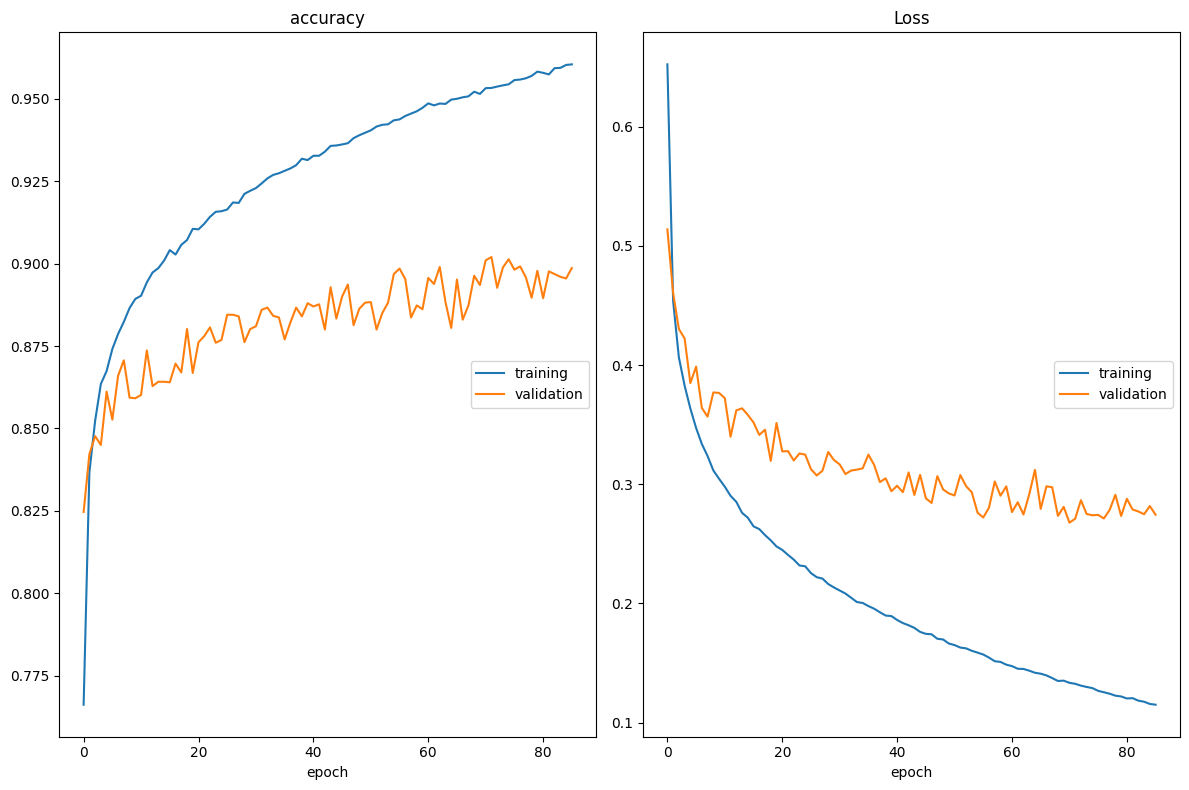

accuracy
	training         	 (min:    0.766, max:    0.960, cur:    0.960)
	validation       	 (min:    0.825, max:    0.902, cur:    0.899)
Loss
	training         	 (min:    0.115, max:    0.652, cur:    0.115)
	validation       	 (min:    0.268, max:    0.514, cur:    0.274)
Restoring model weights from the end of the best epoch: 71.
1688/1688 [==============================] - 12s 7ms/step - loss: 0.1151 - accuracy: 0.9605 - val_loss: 0.2745 - val_accuracy: 0.8987
Epoch 86: early stopping


In [88]:
model2 = Sequential()
NumFilter = 28
FilterSize = (3, 3)

# Feature Learning part    
model2.add(Conv2D(NumFilter, kernel_size=FilterSize, input_shape=(28, 28, 1), activation="relu"))  # stride = 1, padding = valid    
model2.add(MaxPool2D(pool_size=(2, 2), strides =  (1, 1)))  
model2.add(Dropout(dropout_1))
model2.add(Conv2D(filters=filter_2, kernel_size= FilterSize , padding="same", activation="relu"))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2), strides =  (1, 1)))  
model2.add(Dropout(dropout_2))
# Classifeir part
model2.add(Flatten())
model2.add(Dense(128, activation="relu"))
model2.add(Dense(10, activation="softmax"))


# Compile
model2.compile(loss="categorical_crossentropy",  # multiclass problem
              optimizer=optimizer(learning_rate=learning_rate),
              metrics=["accuracy"])


# Stop training when a monitored metric has stopped improving.
early_stop = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True
)



# We are readt to fit the data
model2.fit(
    x=X_train, y=Y_train, validation_split=0.1, batch_size=32, epochs=1000, verbose=1,  # 1000 epoch since there is early stopping
    callbacks=[PlotLossesKeras(), early_stop]  # We add the erarly stop
    
)


313/313 [==============================] - 1s 2ms/step
Test_Set


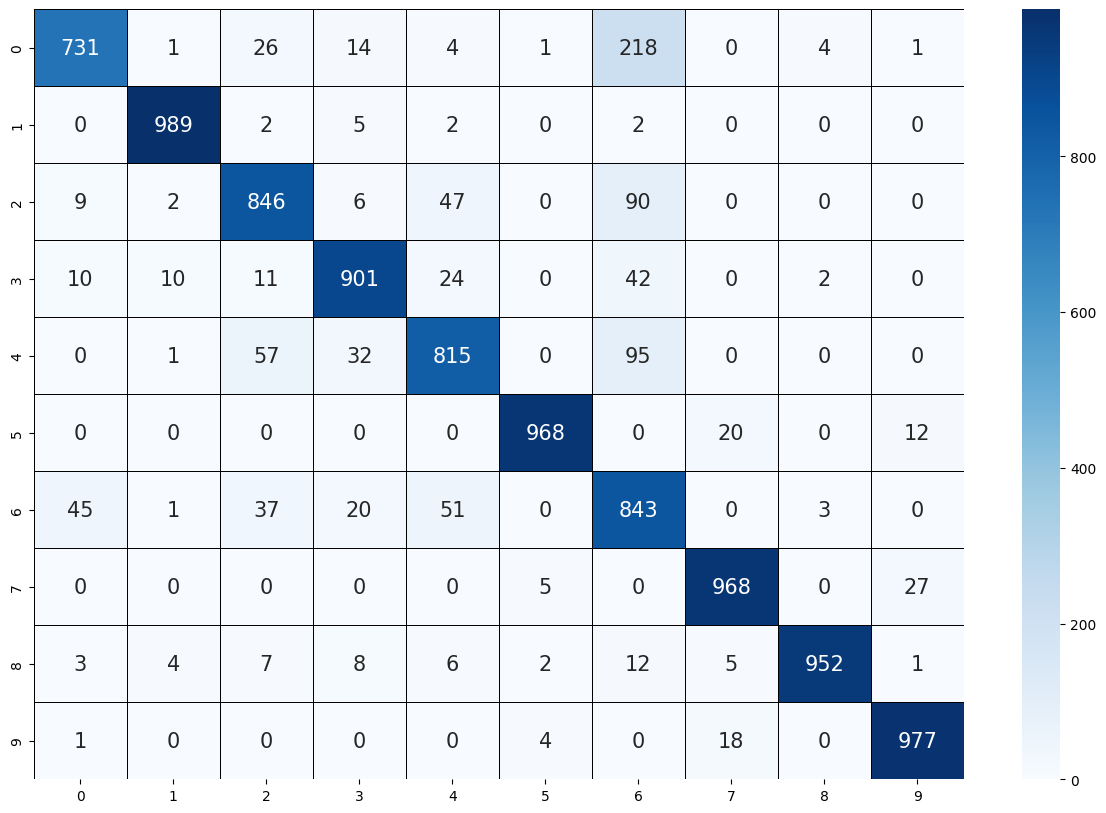

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1000
           1       0.98      0.99      0.99      1000
           2       0.86      0.85      0.85      1000
           3       0.91      0.90      0.91      1000
           4       0.86      0.81      0.84      1000
           5       0.99      0.97      0.98      1000
           6       0.65      0.84      0.73      1000
           7       0.96      0.97      0.96      1000
           8       0.99      0.95      0.97      1000
           9       0.96      0.98      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000


Train_Set


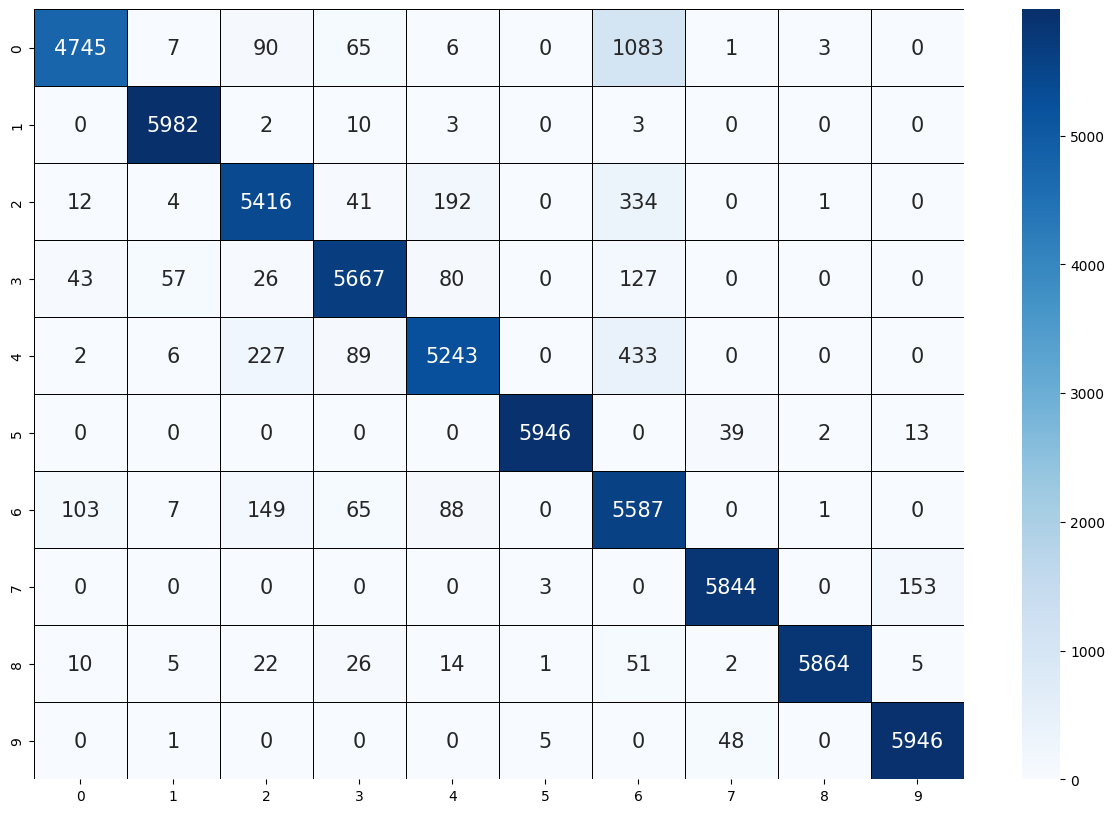

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      6000
           1       0.99      1.00      0.99      6000
           2       0.91      0.90      0.91      6000
           3       0.95      0.94      0.95      6000
           4       0.93      0.87      0.90      6000
           5       1.00      0.99      0.99      6000
           6       0.73      0.93      0.82      6000
           7       0.98      0.97      0.98      6000
           8       1.00      0.98      0.99      6000
           9       0.97      0.99      0.98      6000

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000



In [89]:
eval_metric(model2, X_train, y_train, X_test, y_test)

The recall for class 6 has improved but the precision decreases and also recall of 0 decreases. On other word, it predcited many class 0 as class 6 now.
<br>
Therefore, We will stick with our 1st model since it is less costy

In [90]:
# Save the previous model
model.save("detector_V1.h5")

## Prediction

In [93]:
model_loaded = load_model("detector_V1.h5")

In [94]:
# Check it
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 28)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 17500)             0         
                                                                 
 dense (Dense)               (None, 128)               2240128   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2,241,698
Trainable params: 2,241,698
Non-trainable params: 0
______________________________________________

We don't have a new image. Therfroe, we will use one of the testing images to do so

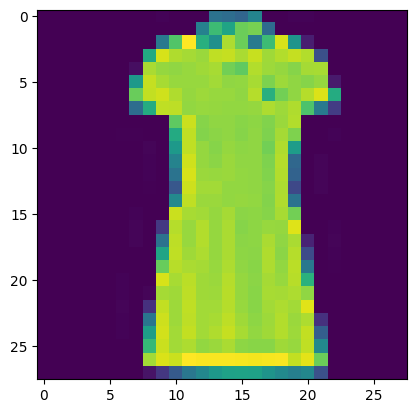

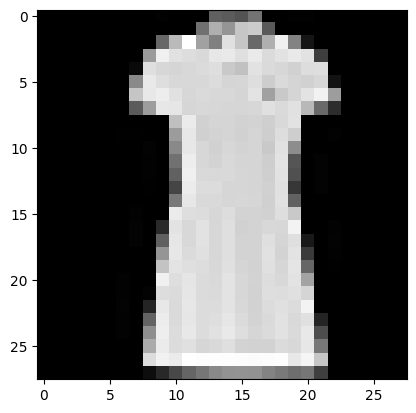

This image is: Dress


In [109]:
import random
i = random.randint(0, len(X_test)-1)

#  view the scale image 
display(plt.imshow(X_test[i]))
plt.show()

#  view the gray scale image 
display(plt.imshow(X_test[i], cmap="gray"))
plt.show()


# What is its class
print("This image is:", classes[y_test[i]])



In [110]:
# Check shape
X_test[i].shape

(28, 28, 1)

In [111]:
#check max & min to see if scaling is needed
print(X_test[i].max())
print(X_test[i].min())

1.0
0.0


We already scaled the testing data in the pre-processing part, so for a real new predcition, remember to do that.
<br>
<br>

Before put it into the model, the model needs to know how many observations he need to predcit. Therfore, we will add a forth dimension 

In [112]:
test = np.expand_dims(X_test[i], axis=0)
test.shape

(1, 28, 28, 1)

Finally, Prediction Time!

In [113]:
model.predict(test)

1/1 [==============================] - 0s 290ms/step


array([[1.06485095e-02, 1.24072676e-06, 4.36947477e-04, 9.63822722e-01,
        1.10665802e-03, 4.37713425e-05, 2.36909818e-02, 1.66137514e-04,
        6.01951833e-05, 2.27069304e-05]], dtype=float32)

I know you wonder how to read it, don't worry

In [115]:
# Get the maximum probability index
np.argmax(model.predict(test))

1/1 [==============================] - 0s 29ms/step


3

In [118]:
classes[3]

'Dress'

It predicted dress which is the real class as shown in the last figure

# End of Assignment

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___